In [68]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder


ContextualVersionConflict: (scipy 1.8.0 (/Users/joonkang/.pyenv/versions/3.9.11/envs/st451_venv/lib/python3.9/site-packages), Requirement.parse('scipy<1.8.0,>=1.7.3'), {'pymc3'})

In [2]:
# Data Source: https://www.openml.org/d/31
# German Credit Risk Data
# *NOTE: To fetch data, please run ~/get_data.sh script
df = pd.read_csv("data/german_credit_risk_data.csv")

# Data

## Data Exploration

In [4]:
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,'<0',6,'critical/other existing credit',radio/tv,1169,'no known savings','>=7',4,'male single',none,...,'real estate',67,none,own,2,skilled,1,yes,yes,good
1,'0<=X<200',48,'existing paid',radio/tv,5951,'<100','1<=X<4',2,'female div/dep/mar',none,...,'real estate',22,none,own,1,skilled,1,none,yes,bad
2,'no checking',12,'critical/other existing credit',education,2096,'<100','4<=X<7',2,'male single',none,...,'real estate',49,none,own,1,'unskilled resident',2,none,yes,good
3,'<0',42,'existing paid',furniture/equipment,7882,'<100','4<=X<7',2,'male single',guarantor,...,'life insurance',45,none,'for free',1,skilled,2,none,yes,good
4,'<0',24,'delayed previously','new car',4870,'<100','1<=X<4',3,'male single',none,...,'no known property',53,none,'for free',2,skilled,2,none,yes,bad


In [8]:
# Non-null data, balanced data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   checking_status         1000 non-null   object
 1   duration                1000 non-null   int64 
 2   credit_history          1000 non-null   object
 3   purpose                 1000 non-null   object
 4   credit_amount           1000 non-null   int64 
 5   savings_status          1000 non-null   object
 6   employment              1000 non-null   object
 7   installment_commitment  1000 non-null   int64 
 8   personal_status         1000 non-null   object
 9   other_parties           1000 non-null   object
 10  residence_since         1000 non-null   int64 
 11  property_magnitude      1000 non-null   object
 12  age                     1000 non-null   int64 
 13  other_payment_plans     1000 non-null   object
 14  housing                 1000 non-null   object
 15  exist

In [10]:
df.describe(include="all")

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
count,1000,1000.000000,1000,1000,1000.000000,1000,1000,1000.000000,1000,1000,...,1000,1000.000000,1000,1000,1000.000000,1000,1000.000000,1000,1000,1000
unique,4,NaN,5,10,NaN,5,5,NaN,4,3,...,4,NaN,3,3,NaN,4,NaN,2,2,2
top,'no checking',NaN,'existing paid',radio/tv,NaN,'<100','1<=X<4',NaN,'male single',none,...,car,NaN,none,own,NaN,skilled,NaN,none,yes,good
freq,394,NaN,530,280,NaN,603,339,NaN,548,907,...,332,NaN,814,713,NaN,630,NaN,596,963,700
mean,NaN,20.903000,NaN,NaN,3271.258000,NaN,NaN,2.973000,NaN,NaN,...,NaN,35.546000,NaN,NaN,1.407000,NaN,1.155000,NaN,NaN,NaN
std,NaN,12.058814,NaN,NaN,2822.736876,NaN,NaN,1.118715,NaN,NaN,...,NaN,11.375469,NaN,NaN,0.577654,NaN,0.362086,NaN,NaN,NaN
min,NaN,4.000000,NaN,NaN,250.000000,NaN,NaN,1.000000,NaN,NaN,...,NaN,19.000000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN
25%,NaN,12.000000,NaN,NaN,1365.500000,NaN,NaN,2.000000,NaN,NaN,...,NaN,27.000000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN
50%,NaN,18.000000,NaN,NaN,2319.500000,NaN,NaN,3.000000,NaN,NaN,...,NaN,33.000000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN
75%,NaN,24.000000,NaN,NaN,3972.250000,NaN,NaN,4.000000,NaN,NaN,...,NaN,42.000000,NaN,NaN,2.000000,NaN,1.000000,NaN,NaN,NaN


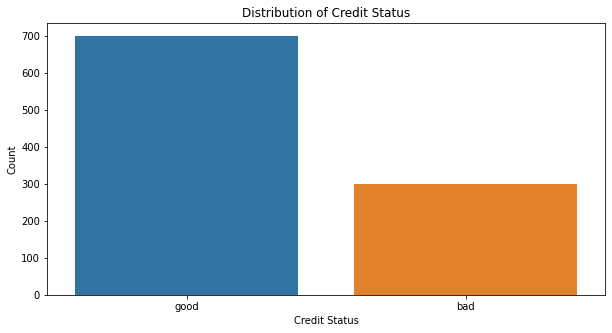

In [23]:
# Target Variable
m = df["class"].value_counts()
m = m.to_frame()
m.reset_index(inplace=True)
m.columns = ["Credit Status", "Count"]
plt.subplots(figsize=(10, 5))
sns.barplot(y="Count", x="Credit Status", data=m)
plt.xlabel("Credit Status")
plt.ylabel("Count")
plt.title("Distribution of Credit Status")
plt.show()


## Data Pre-processing

### Convert target variable to binary variable

In [24]:
# Convert Categorical Variables to Numerical (1 == Bad credit)
def credit_condition(status):
    if status == "good":
        return 0
    else:
        return 1
df["class"] = df["class"].apply(credit_condition)
df["class"].value_counts()

0    700
1    300
Name: class, dtype: int64

### Dummification of categorical variables (OneHotEncoding)

As there are categorical values within the dataset, dummification of categorical variables is required. Label encoding is not used as these categorical variables do not have rank ordering relationship.

In [32]:
cat_features = [
    col for col in df.columns
    if (df[col].dtype == "object") & (col != "class")
]
num_features = [
    col for col in df.columns
    if (df[col].dtype != "object") & (col != "class")
]

In [62]:
df_y = df["class"]
df_x = df.loc[:, num_features].astype("float32")

le_count = 0
onehot_encoders = {}
for col in cat_features:
    oe = OneHotEncoder(handle_unknown='ignore', drop="first")
    onehot_encoders[col] = oe
    df_onehot = pd.DataFrame(oe.fit_transform(df[[col]]).toarray())
    df_onehot.columns = oe.get_feature_names_out()
    le_count += 1
    df_x = pd.concat([df_x, df_onehot], axis=1)
print("%d columns were onehot encoded." % le_count)

13 columns were onehot encoded.


In [65]:
df_y.head()

0    0
1    1
2    0
3    0
4    1
Name: class, dtype: int64

In [64]:
df_x.head()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,checking_status_'<0',checking_status_'>=200',checking_status_'no checking',...,property_magnitude_car,other_payment_plans_none,other_payment_plans_stores,housing_own,housing_rent,job_'unemp/unskilled non res',job_'unskilled resident',job_skilled,own_telephone_yes,foreign_worker_yes
0,6.0,1169.0,4.0,4.0,67.0,2.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
1,48.0,5951.0,2.0,2.0,22.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,12.0,2096.0,2.0,3.0,49.0,1.0,2.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,42.0,7882.0,2.0,4.0,45.0,1.0,2.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,24.0,4870.0,3.0,4.0,53.0,2.0,2.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


Log scale the nominal variable(s), in this case Credit Amount

In [ ]:
df_x["credit_amount"] = np.log(df_x["credit_amount"])

### Data Standardisation

In [67]:
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=9509)